<a href="https://colab.research.google.com/github/doeungim/ADP_DE2/blob/main/%EB%AA%A8%EC%9D%982.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

In [ ]:
import pandas as pd
df =pd.read_csv('/content/drive/MyDrive/ADP_SONY/ADP_SET_2/data/nba.csv')
df.head()

,TEAM_NAME,PLAYER_ID,POSITION_GROUP,GAME_ID,SHOT_MADE,ACTION_TYPE,SHOT_TYPE,ZONE_ABB,LOC_X,LOC_Y,QUARTER,MINS_LEFT,SECS_LEFT
0,team_5,player_1,G,22300003,False,Driving Floating Jump Shot,2PT Field Goal,C,-0.4,17.45,1,11,1
1,team_5,player_2,F,22300003,True,Jump Shot,3PT Field Goal,C,1.5,30.55,1,10,26
2,team_5,player_3,G,22300003,True,Driving Layup Shot,2PT Field Goal,C,-3.3,6.55,1,9,46
3,team_5,player_1,G,22300003,True,Running Finger Roll Layup Shot,2PT Field Goal,C,-1.0,5.85,1,8,30
4,team_5,player_3,G,22300003,True,Cutting Layup Shot,2PT Field Goal,C,-0.0,6.25,1,8,8


- hot_distance (슛거리) : LOC_X, LOX_Y 좌표의 제곱합에 루트를 씌운다
- net_play_time (경기경과시간) : 슛을 시도한 시점의 순 경기 시간을 초(sec)단위로 구한다. 쉬는시간은 고려하지 않는다. 4쿼터 종료시점(MINS_LEFT =0, SECS_LEFT=0)에 슛을 시도했다면 2880 값을 가져야 한다.
- net_score : 해당 게임에 해당팀이 슛을 쏜 결과를 반영한 누적 득점

In [ ]:
# 1. Shot Distance
df1 = df.copy()
df1['shot_distance'] = np.sqrt(df1['LOC_X'] **2 + df1['LOC_Y'] ** 2)

In [ ]:
# 2. Net play time
df1['net_play_time']= df1['QUARTER'] * 12 * 60 - df1['MINS_LEFT'] * 60 - df1['SECS_LEFT']

In [ ]:
# 3.net score
df1['SHOT_MADE_NUM'] = df1['SHOT_MADE'].apply(lambda x : 1 if x == True else 0).astype(int)
df1['score'] = df1['SHOT_MADE_NUM'] * df1['SHOT_TYPE'].str.split('PT').str[0].astype(int)

df1['net_score'] = df1.groupby(['GAME_ID','TEAM_NAME'])['score'].transform('cumsum')
df1.tail()

,TEAM_NAME,PLAYER_ID,POSITION_GROUP,GAME_ID,SHOT_MADE,ACTION_TYPE,SHOT_TYPE,ZONE_ABB,LOC_X,LOC_Y,QUARTER,MINS_LEFT,SECS_LEFT,shot_distance,net_play_time,SHOT_MADE_NUM,score,net_score,minute6
207099,team_28,player_554,G,22301218,False,Jump Shot,3PT Field Goal,LC,11.9,29.85,4,0,48,32.134600,2832,0,0,90,672
207100,team_28,player_556,C,22301218,False,Tip Layup Shot,2PT Field Goal,C,1.6,14.25,4,0,45,14.339543,2835,0,0,90,675
207101,team_28,player_556,C,22301218,True,Jump Shot,2PT Field Goal,C,0.6,9.75,4,0,44,9.768444,2836,1,2,92,676
207102,team_28,player_552,G,22301218,True,Pullup Jump shot,3PT Field Goal,C,-1.7,34.55,4,0,37,34.591798,2843,1,3,95,683
207103,team_28,player_552,G,22301218,False,Pullup Jump shot,3PT Field Goal,RC,-11.0,31.65,4,0,30,33.507051,2850,0,0,95,690


1. 1각 행은 하나의 팀, 하나의 게임 아이디에 대한 정보를 나타낸다.
2. 각 쿼터(1~3쿼터)를 6분간격으로 두 구간으로 나누어 새로운 파생변수를 만든다.
* 1_1_try (1쿼터의 0~6분)의 2점 실패 횟수)(1_1_try_2) , 3점 실패 횟수 (1_1_try_3)
* 1_2_try (1쿼터의 6~12분)의 2점 실패 횟수 (1_1_try_2) ,3점 실패 횟수 (1_1_try_3)
* ~ 3쿼터까지 총 6구간에 대해 12개의 컬럼
3. 해당 게임의 팀별 1쿼터까지 득점, 3쿼터까지의 총 득점(2,3점) (총 2개컬럼, 1_q_score , 3_q_score)
4. 4쿼터 후 최종 승패여부(result) (승 : 1 , 패 :0 ) - 자유투는 없다고 가정, 2,3점 만으로 게임의 승부를 결정, 승부가 결정나지 않은 게임은 없다

In [ ]:
# 초단위로 1쿼터 12분 계산 12 * 60 - 남은 분 - 남은 초
df1['minute6'] = 720 - df1['MINS_LEFT'] * 60 - df1['SECS_LEFT']

# 6분 단위로 나누기 60 * 6 = 360
# 1~3쿼터까지 실패 횟수 - 필터하기

df2 = df1[(df1['QUARTER'].isin([1,2,3])) & (df1['SHOT_MADE'] == False)].reset_index(drop = True)

# 6분 단위로 나누기
df2['quarter6'] = df2['minute6'].apply(lambda x : '1' if x < 361 else '2')

# category만들기
df2['group'] = df2['QUARTER'].astype(str) + '_'+ df2['quarter6'] + '_try_'+ df2['SHOT_TYPE'].str.split('PT').str[0].astype(str)

##pivoting
pivot_df = df2[['GAME_ID','TEAM_NAME','group']].pivot_table(index = ['GAME_ID','TEAM_NAME'], columns = 'group', aggfunc='size').reset_index()
pivot_df.columns.name = None
pivot_df

,GAME_ID,TEAM_NAME,1_1_try_2,1_1_try_3,1_2_try_2,1_2_try_3,2_1_try_2,2_1_try_3,2_2_try_2,2_2_try_3,3_1_try_2,3_1_try_3,3_2_try_2,3_2_try_3
0,22300001,team_1,5.0,2.0,3.0,1.0,3.0,1.0,2.0,3.0,4.0,3.0,4.0,3.0
1,22300001,team_2,5.0,2.0,2.0,3.0,3.0,2.0,1.0,5.0,3.0,1.0,1.0,1.0
2,22300002,team_3,7.0,3.0,7.0,3.0,NaN,5.0,7.0,3.0,NaN,6.0,NaN,5.0
3,22300002,team_4,1.0,1.0,6.0,4.0,4.0,3.0,4.0,NaN,3.0,3.0,4.0,3.0
4,22300003,team_5,1.0,NaN,1.0,2.0,6.0,1.0,2.0,4.0,3.0,3.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2337,22301228,team_27,3.0,7.0,1.0,3.0,4.0,4.0,6.0,3.0,4.0,1.0,2.0,1.0
2338,22301229,team_1,2.0,2.0,6.0,3.0,5.0,1.0,NaN,6.0,2.0,6.0,1.0,3.0
2339,22301229,team_4,4.0,1.0,6.0,3.0,6.0,1.0,2.0,3.0,NaN,3.0,7.0,1.0
2340,22301230,team_19,5.0,2.0,5.0,3.0,6.0,1.0,NaN,4.0,5.0,4.0,5.0,3.0


In [ ]:
# 해당 게임의 팀별 1쿼터까지 득점, 3쿼터까지의 총 득점(2,3점) (총 2개컬럼, 1_q_score , 3_q_score)

q13 =df1[df1['QUARTER'].isin([1,3])][['GAME_ID','TEAM_NAME','QUARTER','net_score']]

pivot13 = q13.groupby(['GAME_ID','TEAM_NAME','QUARTER'])['net_score'].max().reset_index()

pivot13= pivot13.pivot_table(index = ['GAME_ID','TEAM_NAME'], columns = 'QUARTER', values = 'net_score').reset_index()
pivot13.columns = ['GAME_ID','TEAM_NAME','Q1_score', 'Q3_score']
pivot13.head()

,GAME_ID,TEAM_NAME,Q1_score,Q3_score
0,22300001,team_1,33.0,79.0
1,22300001,team_2,24.0,76.0
2,22300002,team_3,24.0,62.0
3,22300002,team_4,20.0,74.0
4,22300003,team_5,33.0,78.0


In [ ]:
# 4쿼터 후 최종 승패여부(result) (승 : 1 , 패 :0 ) - 자유투는 없다고 가정, 2,3점 만으로 게임의 승부를 결정
res = df1.groupby(['GAME_ID','TEAM_NAME'])['net_score'].max().reset_index()
res = res.sort_values(by = ['GAME_ID', 'net_score'], ascending = [True, True])
res['result'] = res.groupby(['GAME_ID'])['net_score'].cumcount()
res.head(10)

,GAME_ID,TEAM_NAME,net_score,result
1,22300001,team_2,96,0
0,22300001,team_1,105,1
2,22300002,team_3,86,0
3,22300002,team_4,90,1
4,22300003,team_5,105,0
5,22300003,team_6,109,1
6,22300004,team_7,97,0
7,22300004,team_8,106,1
9,22300005,team_9,115,0
8,22300005,team_10,116,1


In [ ]:
f_df = pd.merge(pd.merge(pivot_df, pivot13, how = 'left') , res, how = 'left').fillna(0).reset_index(drop= True)
f_df.head(6)

,GAME_ID,TEAM_NAME,1_1_try_2,1_1_try_3,1_2_try_2,1_2_try_3,2_1_try_2,2_1_try_3,2_2_try_2,2_2_try_3,3_1_try_2,3_1_try_3,3_2_try_2,3_2_try_3,Q1_score,Q3_score,net_score,result
0,22300001,team_1,5.0,2.0,3.0,1.0,3.0,1.0,2.0,3.0,4.0,3.0,4.0,3.0,33.0,79.0,105,1
1,22300001,team_2,5.0,2.0,2.0,3.0,3.0,2.0,1.0,5.0,3.0,1.0,1.0,1.0,24.0,76.0,96,0
2,22300002,team_3,7.0,3.0,7.0,3.0,0.0,5.0,7.0,3.0,0.0,6.0,0.0,5.0,24.0,62.0,86,0
3,22300002,team_4,1.0,1.0,6.0,4.0,4.0,3.0,4.0,0.0,3.0,3.0,4.0,3.0,20.0,74.0,90,1
4,22300003,team_5,1.0,0.0,1.0,2.0,6.0,1.0,2.0,4.0,3.0,3.0,1.0,1.0,33.0,78.0,105,0
5,22300003,team_6,2.0,1.0,2.0,1.0,3.0,1.0,4.0,2.0,1.0,1.0,2.0,2.0,28.0,90.0,109,1


- game_id가 홀수로 끝나는 경우는 승리팀만, 짝수를 끝나는 경우는 패배팀만 필터한다.
- 랜덤포레스트와 xgb를 사용하여 모델링을 진행하라. 데이터의 층화 추출을 통해 70%의 데이터로 학습하고 30% 데이터로 검증

  Model Name     Score
0         RF  0.718563
1        xgb  0.721557


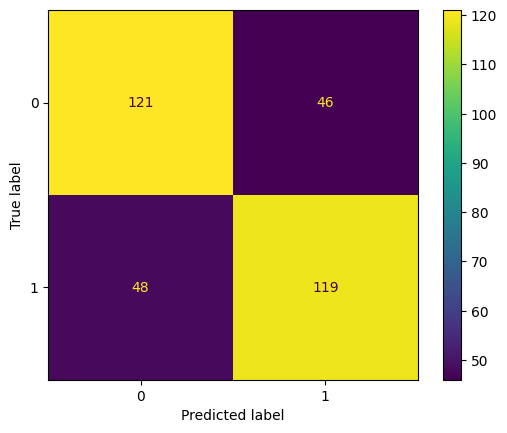

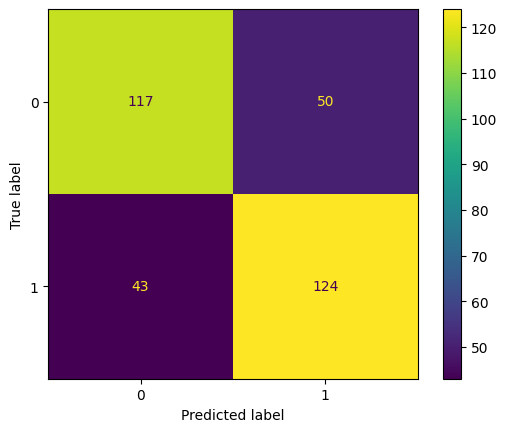

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix

winner = f_df[f_df.index % 2 != 0].query('result == 1')
lose =  f_df[f_df.index % 2 == 0].query('result == 0')


m_df = pd.concat([winner, lose], axis = 0).reset_index(drop =True)

X = m_df.drop(columns = ['result','GAME_ID','TEAM_NAME'], axis =1)
y = m_df['result']

def eval(name, model) :
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42 , stratify= y)
  model.fit(x_train, y_train)
  pred = model.predict(x_test)
  acc = accuracy_score(y_test, pred)

  cm = confusion_matrix(y_test, pred)
  display = ConfusionMatrixDisplay(cm)
  display.plot()

  return name, acc

result = []
res = []
for name, model in [['RF', RandomForestClassifier()], ['xgb' , xgb.XGBClassifier()]] :
    best_model, score = eval(name, model)
    result.append({
        'Model Name' : name,
        'Score' : score
    })
    res.append([name, score])

print(pd.DataFrame(result))

#### 캘리포니아 집값

In [ ]:
from sklearn.datasets import fetch_california_housing
cali = fetch_california_housing()
X,y=pd.DataFrame(cali.data,columns =cali['feature_names']), pd.DataFrame(cali.target,columns =['MedHouseVal'])
display(X.head())
display(y.head())

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


,MedHouseVal
0,4.526
1,3.585
2,3.521
3,3.413
4,3.422


#### 변수들의 다중공선성을 검토하라

In [ ]:
X.iloc[:,:-2]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467
...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209


In [ ]:
cor_df = X.iloc[:,:-2].corr(method = 'spearman').unstack().reset_index()
cor_df.columns = ['col1','col2','corr']
cor_df[(cor_df['col1'] != cor_df['col2']) & (cor_df['corr'].abs() >= 0.5)]

,col1,col2,corr
2,MedInc,AveRooms,0.643671
12,AveRooms,MedInc,0.643671


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

v_df = pd.DataFrame()
v_df['col'] = X.iloc[:,:-2].columns
v_df['VIF'] = [variance_inflation_factor(X.iloc[:,:-2].values, i) for i in range(X.iloc[:,:-2].shape[1])]
v_df

,col,VIF
0,MedInc,7.766787
1,HouseAge,4.309941
2,AveRooms,41.111592
3,AveBedrms,34.118257
4,Population,2.322315
5,AveOccup,1.094793


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/doeungim/ADP_DE/refs/heads/main/ADP_SET2/data/s5.csv')
df.head()

,w
0,78.8
1,72.0
2,74.9
3,81.2
4,79.3


In [ ]:
from scipy.stats import norm
n = 183
x = df['w'].mean()
s = df['w'].std()

se = s/ np.sqrt(n)

# z값
z1 = (69.5 -x) / se
z2 = (70.1 -x) / se

norm.cdf(z2) - norm.cdf(z1)

np.float64(0.5876910371573993)